In [1]:
"""
=============================================================================
NOTEBOOK 01: DATA PIPELINE
=============================================================================
This notebook covers:
1. Loading and exploring the OCR CSV data
2. Path mapping (GCP paths → Delta paths)
3. Validating image-CSV alignment
4. Filtering advertisement pages
5. Creating train/val/test splits

Author: Harsha Sekar
Date: November 30, 2025
Project: Multimodal Cloze in Comics with Vision-Language Models
=============================================================================
"""

# Standard libraries
import os
import json
from pathlib import Path

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# Progress bar
from tqdm import tqdm

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ All imports successful!")

✅ All imports successful!


In [2]:
"""
=============================================================================
CONFIGURATION
=============================================================================
Define all paths and settings in one place for easy modification.
"""

# =============================================================================
# PATH CONFIGURATION
# =============================================================================

# Base project directory
PROJECT_DIR = Path("/scratch/bftl/hsekar/comics_project")

# Data paths
DATA_DIR = PROJECT_DIR / "data"
IMAGES_DIR = DATA_DIR / "images"
OCR_DIR = DATA_DIR / "ocr"
OCR_CSV_PATH = OCR_DIR / "COMICS_OCR_WAVE1_sorted.csv"

# Output paths
OUTPUTS_DIR = PROJECT_DIR / "outputs"
CHECKPOINTS_DIR = PROJECT_DIR / "checkpoints"

# =============================================================================
# DATASET CONFIGURATION
# =============================================================================

# How many comics to use (set to None for all comics)
NUM_COMICS = None  # Use all 1,441 comics
# NUM_COMICS = 100  # Uncomment for quick testing with 100 comics

# Context window: how many previous panels to show the model
CONTEXT_WINDOW_SIZE = 3

# Random seed for reproducibility
RANDOM_SEED = 42

# =============================================================================
# SPLIT STRATEGY CONFIGURATION
# =============================================================================

# Choose your split strategy:
#   "holdout"  - Simple 70/15/15 split (faster, good for tight deadlines)
#   "kfold"    - K-Fold cross-validation (more robust, 5x training time)

SPLIT_STRATEGY = "holdout"  # Options: "holdout" or "kfold"

# Holdout configuration (used if SPLIT_STRATEGY = "holdout")
HOLDOUT_RATIOS = {
    "train": 0.70,
    "val": 0.15,
    "test": 0.15
}

# K-Fold configuration (used if SPLIT_STRATEGY = "kfold")
KFOLD_SPLITS = 5  # Number of folds

# =============================================================================
# VERIFY PATHS EXIST
# =============================================================================

print("📁 Path Configuration:")
print(f"   Project directory: {PROJECT_DIR}")
print(f"   Images directory:  {IMAGES_DIR} {'✅ Exists' if IMAGES_DIR.exists() else '❌ NOT FOUND'}")
print(f"   OCR CSV path:      {OCR_CSV_PATH} {'✅ Exists' if OCR_CSV_PATH.exists() else '❌ NOT FOUND'}")
print()
print("⚙️ Dataset Configuration:")
print(f"   Comics to use:     {'All' if NUM_COMICS is None else NUM_COMICS}")
print(f"   Context window:    {CONTEXT_WINDOW_SIZE} panels")
print(f"   Random seed:       {RANDOM_SEED}")
print()
print("📊 Split Strategy:")
print(f"   Strategy:          {SPLIT_STRATEGY.upper()}")
if SPLIT_STRATEGY == "holdout":
    print(f"   Train/Val/Test:    {HOLDOUT_RATIOS['train']*100:.0f}% / {HOLDOUT_RATIOS['val']*100:.0f}% / {HOLDOUT_RATIOS['test']*100:.0f}%")
else:
    print(f"   Number of folds:   {KFOLD_SPLITS}")
    print(f"   ⚠️ Note: K-Fold requires {KFOLD_SPLITS}x training time!")

📁 Path Configuration:
   Project directory: /scratch/bftl/hsekar/comics_project
   Images directory:  /scratch/bftl/hsekar/comics_project/data/images ✅ Exists
   OCR CSV path:      /scratch/bftl/hsekar/comics_project/data/ocr/COMICS_OCR_WAVE1_sorted.csv ✅ Exists

⚙️ Dataset Configuration:
   Comics to use:     All
   Context window:    3 panels
   Random seed:       42

📊 Split Strategy:
   Strategy:          HOLDOUT
   Train/Val/Test:    70% / 15% / 15%


In [3]:
"""
=============================================================================
LOAD OCR DATA
=============================================================================
Load the CSV and perform initial exploration.
"""

# Load the OCR CSV
print("📂 Loading OCR CSV...")
df = pd.read_csv(OCR_CSV_PATH)
print(f"✅ Loaded {len(df):,} rows")

# =============================================================================
# BASIC STATISTICS
# =============================================================================

print("\n" + "="*60)
print("📊 BASIC STATISTICS")
print("="*60)

print(f"\n📈 Dataset Size:")
print(f"   Total panels:      {len(df):,}")
print(f"   Unique comics:     {df['comic_no'].nunique():,}")
print(f"   Comic range:       {df['comic_no'].min()} to {df['comic_no'].max()}")

print(f"\n📄 Pages & Panels:")
print(f"   Total pages:       {df.groupby('comic_no')['page_no'].nunique().sum():,}")
print(f"   Panels per comic:  {df.groupby('comic_no').size().mean():.1f} (avg)")
print(f"                      {df.groupby('comic_no').size().min()} (min)")
print(f"                      {df.groupby('comic_no').size().max()} (max)")

print(f"\n💬 Text Statistics:")
print(f"   Panels with text:  {df['agg_text'].notna().sum():,} ({df['agg_text'].notna().mean()*100:.1f}%)")
print(f"   Panels no text:    {df['agg_text'].isna().sum():,} ({df['agg_text'].isna().mean()*100:.1f}%)")

print(f"\n🔢 Bubble Count Distribution:")
print(df['bubble_count'].describe().to_string())

# =============================================================================
# PREVIEW DATA
# =============================================================================

print("\n" + "="*60)
print("👀 DATA PREVIEW (First 5 rows)")
print("="*60)
df.head()

📂 Loading OCR CSV...
✅ Loaded 420,000 rows

📊 BASIC STATISTICS

📈 Dataset Size:
   Total panels:      420,000
   Unique comics:     1,441
   Comic range:       0 to 1447

📄 Pages & Panels:
   Total pages:       65,680
   Panels per comic:  291.5 (avg)
                      19 (min)
                      1499 (max)

💬 Text Statistics:
   Panels with text:  411,334 (97.9%)
   Panels no text:    8,666 (2.1%)

🔢 Bubble Count Distribution:
count    420000.000000
mean          2.153376
std           1.200414
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          14.000000

👀 DATA PREVIEW (First 5 rows)


,comic_no,page_no,panel_no,img_path,agg_text,bubble_count,bubbles_json
0,0,0,0,raw_panel_images/0/0_0.jpg,JULY No.30 10c BINKS ARMORED DELIVERY MAIN ST.,3,"{""bubbles"": [{""text"": ""JULY\nNo.30\n10c"", ""raw_text"": ""JULY\nNo.30\n10c"", ""type"": ""narration""}, ..."
1,0,0,1,raw_panel_images/0/0_1.jpg,G ACCOUNT OF ss Wiggins MAN WHO OKE LAW OF AVITY! No.30 10c BINKS ARMORED DELIVERY MAIN ST 5 COM...,6,"{""bubbles"": [{""text"": ""G ACCOUNT OF\nss Wiggins"", ""raw_text"": ""G ACCOUNT OF\nss Wiggins"", ""type""..."
2,0,2,0,raw_panel_images/0/2_0.jpg,"CK HIM ,PLAS! CK HIM WN! PLASTIC MAN",2,"{""bubbles"": [{""text"": ""CK HIM\n,PLAS!\nCK HIM\nWN!"", ""raw_text"": ""CK HIM\n,PLAS!\nCK HIM\nWN!"", ..."
3,0,2,1,raw_panel_images/0/2_1.jpg,"PLASTICMAN IN HIS CAREER AS AS CRIME-FIGHTER, PLASTIC MAN, FEARLESS AGENT OF THE F.B.I., HAS ENC...",3,"{""bubbles"": [{""text"": ""PLASTICMAN"", ""raw_text"": ""PLASTICMAN"", ""type"": ""sign""}, {""text"": ""IN HIS ..."
4,0,3,0,raw_panel_images/0/3_0.jpg,NOW IF I PUT THIS HERE... AND THIS ONE HERE...,1,"{""bubbles"": [{""text"": ""NOW IF I PUT THIS HERE... AND THIS ONE HERE..."", ""raw_text"": ""NOW IF I PU..."


In [4]:
"""
=============================================================================
PATH MAPPING
=============================================================================
Convert GCP paths in CSV to Delta local paths.
"""

def gcp_to_delta_path(gcp_path: str) -> Path:
    """
    Convert GCP path format to Delta local path.
    
    Example:
        Input:  'raw_panel_images/0/0_0.jpg'
        Output: '/scratch/bftl/hsekar/comics_project/data/images/0/0_0.jpg'
    """
    # Remove the 'raw_panel_images/' prefix and build Delta path
    relative_path = gcp_path.replace('raw_panel_images/', '')
    delta_path = IMAGES_DIR / relative_path
    return delta_path


# =============================================================================
# ADD DELTA PATH COLUMN
# =============================================================================

print("🔄 Adding Delta paths to dataframe...")
df['delta_path'] = df['img_path'].apply(gcp_to_delta_path)

# Preview the mapping
print("\n📍 Path Mapping Examples:")
print("-" * 80)
for i in range(3):
    print(f"   GCP:   {df.iloc[i]['img_path']}")
    print(f"   Delta: {df.iloc[i]['delta_path']}")
    print()

print("✅ Delta paths added successfully!")
print(f"   New column: 'delta_path'")
print(f"   Total rows with paths: {len(df):,}")

🔄 Adding Delta paths to dataframe...

📍 Path Mapping Examples:
--------------------------------------------------------------------------------
   GCP:   raw_panel_images/0/0_0.jpg
   Delta: /scratch/bftl/hsekar/comics_project/data/images/0/0_0.jpg

   GCP:   raw_panel_images/0/0_1.jpg
   Delta: /scratch/bftl/hsekar/comics_project/data/images/0/0_1.jpg

   GCP:   raw_panel_images/0/2_0.jpg
   Delta: /scratch/bftl/hsekar/comics_project/data/images/0/2_0.jpg

✅ Delta paths added successfully!
   New column: 'delta_path'
   Total rows with paths: 420,000


In [ ]:
"""
=============================================================================
VALIDATE IMAGE-CSV ALIGNMENT
=============================================================================
Ensure every CSV entry has a corresponding image file on Delta.
This is critical - missing images will cause errors during training!
"""

print("🔍 Validating image-CSV alignment...")
print("   (This may take a minute for 420K files...)\n")

# Check which images exist
missing_images = []
existing_images = 0

# Use tqdm for progress bar
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking images"):
    if row['delta_path'].exists():
        existing_images += 1
    else:
        missing_images.append({
            'index': idx,
            'comic_no': row['comic_no'],
            'page_no': row['page_no'],
            'panel_no': row['panel_no'],
            'path': str(row['delta_path'])
        })

# =============================================================================
# REPORT RESULTS
# =============================================================================

print("\n" + "="*60)
print("📊 VALIDATION RESULTS")
print("="*60)

print(f"\n✅ Images found:    {existing_images:,} ({existing_images/len(df)*100:.2f}%)")
print(f"❌ Images missing:  {len(missing_images):,} ({len(missing_images)/len(df)*100:.2f}%)")

if len(missing_images) > 0:
    print(f"\n⚠️ Missing image examples (first 5):")
    for img in missing_images[:5]:
        print(f"   Comic {img['comic_no']}, Page {img['page_no']}, Panel {img['panel_no']}")
        print(f"   Path: {img['path']}")
else:
    print("\n🎉 Perfect alignment! All CSV entries have matching images.")

🔍 Validating image-CSV alignment...
   (This may take a minute for 420K files...)



Checking images: 100%|██████████| 420000/420000 [1:16:10<00:00, 91.90it/s] 


📊 VALIDATION RESULTS

✅ Images found:    420,000 (100.00%)
❌ Images missing:  0 (0.00%)

🎉 Perfect alignment! All CSV entries have matching images.


🖼️ Displaying 8 random panels with OCR text:

   Comic 357, Page 16, Panel 6
   Comic 1262, Page 27, Panel 0
   Comic 425, Page 26, Panel 1
   Comic 941, Page 27, Panel 5
   Comic 823, Page 11, Panel 1
   Comic 974, Page 24, Panel 2
   Comic 854, Page 6, Panel 7
   Comic 925, Page 15, Panel 2


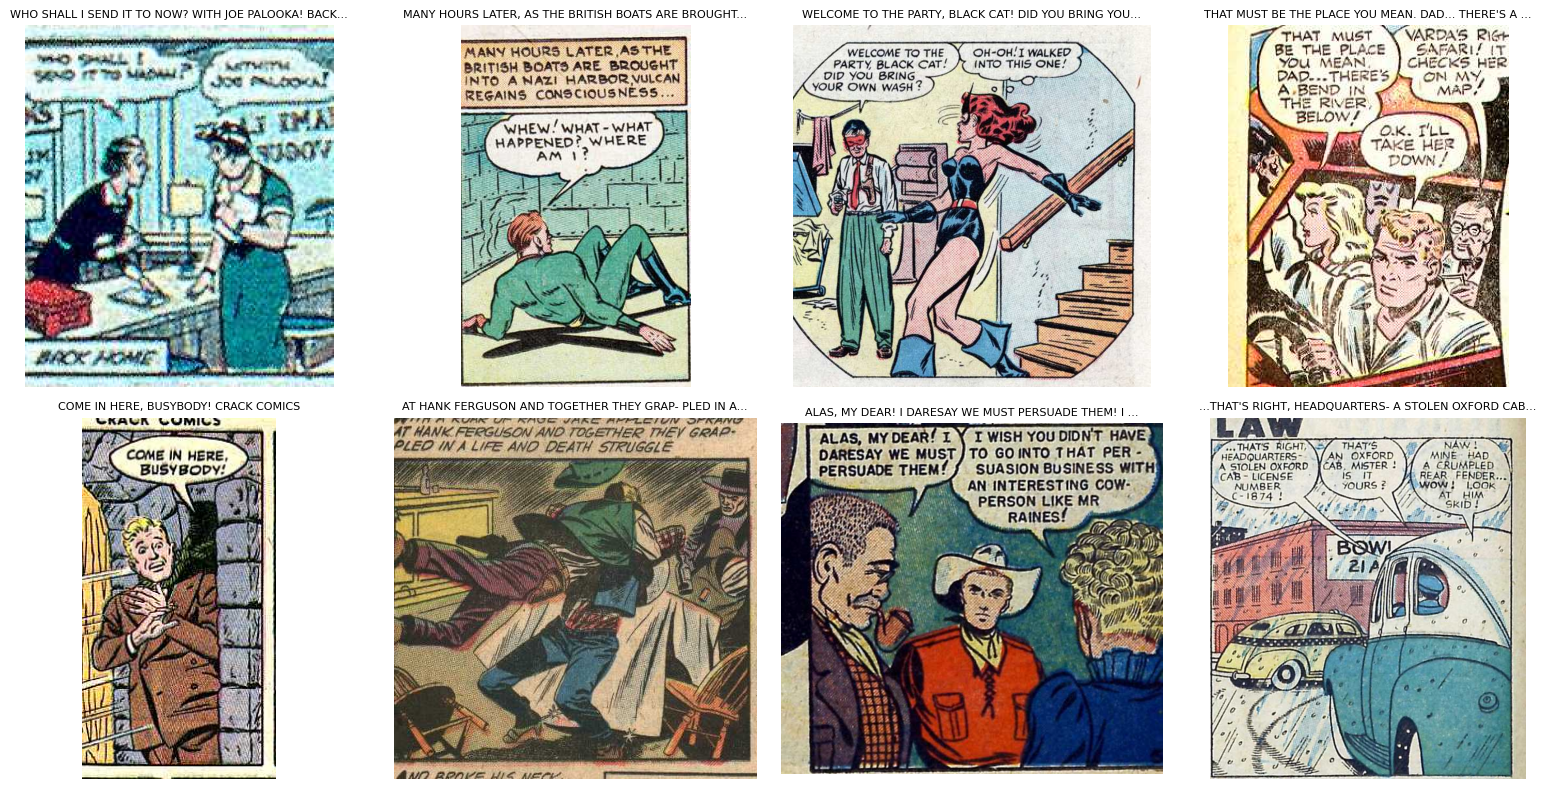


✅ Sample visualization saved to: /scratch/bftl/hsekar/comics_project/outputs/sample_panels.png


In [6]:
"""
=============================================================================
VISUALIZE SAMPLE IMAGES
=============================================================================
Display a few sample panels with their OCR text to verify data quality.
"""

def display_panel(row, ax):
    """Display a single panel with its OCR text."""
    # Load image
    img = Image.open(row['delta_path'])
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Create title with OCR text (truncated if too long)
    text = row['agg_text'] if pd.notna(row['agg_text']) else "[NO TEXT]"
    if len(text) > 50:
        text = text[:50] + "..."
    ax.set_title(text, fontsize=8, wrap=True)


# =============================================================================
# DISPLAY RANDOM SAMPLES
# =============================================================================

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

# Select 8 random panels
sample_indices = np.random.choice(len(df), size=8, replace=False)
sample_rows = df.iloc[sample_indices]

# Create figure
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

print("🖼️ Displaying 8 random panels with OCR text:\n")

for ax, (idx, row) in zip(axes, sample_rows.iterrows()):
    display_panel(row, ax)
    print(f"   Comic {row['comic_no']}, Page {row['page_no']}, Panel {row['panel_no']}")

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'sample_panels.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Sample visualization saved to: {OUTPUTS_DIR / 'sample_panels.png'}")

In [7]:
"""
=============================================================================
VIEW FULL OCR TEXT FOR SAMPLE PANELS
=============================================================================
Display the complete (non-truncated) OCR text for the sample panels.
"""

print("📝 Full OCR text for the 8 sample panels:\n")
print("="*80)

for idx, row in sample_rows.iterrows():
    print(f"\n📍 Comic {row['comic_no']}, Page {row['page_no']}, Panel {row['panel_no']}")
    print(f"   Bubbles: {row['bubble_count']}")
    print(f"   Text length: {len(str(row['agg_text'])) if pd.notna(row['agg_text']) else 0} characters")
    print("-"*80)
    
    if pd.notna(row['agg_text']):
        print(row['agg_text'])
    else:
        print("[NO TEXT]")
    
    print()

📝 Full OCR text for the 8 sample panels:


📍 Comic 357, Page 16, Panel 6
   Bubbles: 3
   Text length: 55 characters
--------------------------------------------------------------------------------
WHO SHALL I SEND IT TO NOW? WITH JOE PALOOKA! BACK HOME


📍 Comic 1262, Page 27, Panel 0
   Bubbles: 2
   Text length: 140 characters
--------------------------------------------------------------------------------
MANY HOURS LATER, AS THE BRITISH BOATS ARE BROUGHT INTO A NAZI HARBOR, VULCAN REGAINS CONSCIOUSNESS... WHEW! WHAT-WHAT HAPPENED? WHERE AM I?


📍 Comic 425, Page 26, Panel 1
   Bubbles: 2
   Text length: 92 characters
--------------------------------------------------------------------------------
WELCOME TO THE PARTY, BLACK CAT! DID YOU BRING YOUR OWN WASH? OH-OH! I WALKED INTO THIS ONE!


📍 Comic 941, Page 27, Panel 5
   Bubbles: 3
   Text length: 147 characters
--------------------------------------------------------------------------------
THAT MUST BE THE PLACE YOU MEAN. DAD..

In [8]:
"""
=============================================================================
CREATE TRAIN/VAL/TEST SPLITS
=============================================================================
Split the data at the COMIC level (not panel level) to prevent data leakage.

Why comic-level splits?
- Panels within a comic are sequential and related
- If we split at panel level, the model could "cheat" by seeing 
  context panels in training and target panels in test
- Comic-level splits ensure complete story separation
"""

from sklearn.model_selection import train_test_split

# =============================================================================
# GET UNIQUE COMICS
# =============================================================================

unique_comics = df['comic_no'].unique()
print(f"📚 Total unique comics: {len(unique_comics):,}")

# =============================================================================
# SPLIT COMICS (NOT PANELS)
# =============================================================================

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

if SPLIT_STRATEGY == "holdout":
    # First split: train vs (val + test)
    train_comics, temp_comics = train_test_split(
        unique_comics,
        train_size=HOLDOUT_RATIOS['train'],
        random_state=RANDOM_SEED
    )
    
    # Second split: val vs test (split the remaining 30% into 15%/15%)
    val_ratio_adjusted = HOLDOUT_RATIOS['val'] / (HOLDOUT_RATIOS['val'] + HOLDOUT_RATIOS['test'])
    val_comics, test_comics = train_test_split(
        temp_comics,
        train_size=val_ratio_adjusted,
        random_state=RANDOM_SEED
    )
    
    print(f"\n📊 Comic-level splits (Holdout Strategy):")
    print(f"   Train: {len(train_comics):,} comics ({len(train_comics)/len(unique_comics)*100:.1f}%)")
    print(f"   Val:   {len(val_comics):,} comics ({len(val_comics)/len(unique_comics)*100:.1f}%)")
    print(f"   Test:  {len(test_comics):,} comics ({len(test_comics)/len(unique_comics)*100:.1f}%)")

# =============================================================================
# CREATE PANEL-LEVEL SPLITS BASED ON COMIC SPLITS
# =============================================================================

train_df = df[df['comic_no'].isin(train_comics)].copy()
val_df = df[df['comic_no'].isin(val_comics)].copy()
test_df = df[df['comic_no'].isin(test_comics)].copy()

print(f"\n📄 Panel-level splits:")
print(f"   Train: {len(train_df):,} panels ({len(train_df)/len(df)*100:.1f}%)")
print(f"   Val:   {len(val_df):,} panels ({len(val_df)/len(df)*100:.1f}%)")
print(f"   Test:  {len(test_df):,} panels ({len(test_df)/len(df)*100:.1f}%)")

# =============================================================================
# VERIFY NO DATA LEAKAGE
# =============================================================================

train_comic_set = set(train_comics)
val_comic_set = set(val_comics)
test_comic_set = set(test_comics)

# Check for overlaps
train_val_overlap = train_comic_set.intersection(val_comic_set)
train_test_overlap = train_comic_set.intersection(test_comic_set)
val_test_overlap = val_comic_set.intersection(test_comic_set)

print(f"\n🔒 Data Leakage Check:")
print(f"   Train ∩ Val overlap:  {len(train_val_overlap)} comics {'✅' if len(train_val_overlap) == 0 else '❌'}")
print(f"   Train ∩ Test overlap: {len(train_test_overlap)} comics {'✅' if len(train_test_overlap) == 0 else '❌'}")
print(f"   Val ∩ Test overlap:   {len(val_test_overlap)} comics {'✅' if len(val_test_overlap) == 0 else '❌'}")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print("\n🎉 No data leakage! Splits are clean.")

📚 Total unique comics: 1,441

📊 Comic-level splits (Holdout Strategy):
   Train: 1,008 comics (70.0%)
   Val:   216 comics (15.0%)
   Test:  217 comics (15.1%)

📄 Panel-level splits:
   Train: 290,018 panels (69.1%)
   Val:   62,673 panels (14.9%)
   Test:  67,309 panels (16.0%)

🔒 Data Leakage Check:
   Train ∩ Val overlap:  0 comics ✅
   Train ∩ Test overlap: 0 comics ✅
   Val ∩ Test overlap:   0 comics ✅

🎉 No data leakage! Splits are clean.


In [9]:
"""
=============================================================================
SAVE PROCESSED DATA
=============================================================================
Save the train/val/test splits for use in training and evaluation.
"""

# Create processed data directory
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

# =============================================================================
# SAVE SPLIT DATAFRAMES
# =============================================================================

print("💾 Saving processed splits...")

# Save as CSV (human-readable)
train_df.to_csv(PROCESSED_DIR / "train.csv", index=False)
val_df.to_csv(PROCESSED_DIR / "val.csv", index=False)
test_df.to_csv(PROCESSED_DIR / "test.csv", index=False)

print(f"   ✅ train.csv: {len(train_df):,} panels")
print(f"   ✅ val.csv:   {len(val_df):,} panels")
print(f"   ✅ test.csv:  {len(test_df):,} panels")

# =============================================================================
# SAVE COMIC SPLIT MAPPING
# =============================================================================

split_info = {
    'train_comics': train_comics.tolist(),
    'val_comics': val_comics.tolist(),
    'test_comics': test_comics.tolist(),
    'config': {
        'strategy': SPLIT_STRATEGY,
        'ratios': HOLDOUT_RATIOS,
        'random_seed': RANDOM_SEED,
        'total_comics': len(unique_comics),
        'total_panels': len(df)
    }
}

with open(PROCESSED_DIR / "split_info.json", 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"   ✅ split_info.json: Split configuration saved")

# =============================================================================
# VERIFY SAVED FILES
# =============================================================================

print(f"\n📁 Saved files in {PROCESSED_DIR}:")
for file in PROCESSED_DIR.iterdir():
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name}: {size_mb:.1f} MB")

print("\n🎉 Data pipeline complete!")

💾 Saving processed splits...
   ✅ train.csv: 290,018 panels
   ✅ val.csv:   62,673 panels
   ✅ test.csv:  67,309 panels
   ✅ split_info.json: Split configuration saved

📁 Saved files in /scratch/bftl/hsekar/comics_project/data/processed:
   val.csv: 36.9 MB
   train.csv: 169.8 MB
   test.csv: 38.8 MB
   split_info.json: 0.0 MB

🎉 Data pipeline complete!
